In [1]:
import time
import os
import math
import cv2
import numpy as np
import pandas as pd
import pyautogui as pa
import shutil
import imageio
import re  # regex
from PIL import Image, ImageDraw
import random
from scipy.stats import sem, ttest_ind, norm
from scipy.optimize import curve_fit
import seaborn as sns

from lib.analysis.trace_metrics import TraceMetrics
from lib.analysis.false_discovery_control import false_discovery_control
from lib.auto_GUI.auto_PhotoZ import AutoPhotoZ
from lib.analysis.laminar_dist import *
from lib.file.TIF import *
from lib.analysis.align import ImageAlign
from lib.utilities import *
from lib.file.ROI_writer import ROIFileWriter
from lib.file.ROI_reader import ROIFileReader
from lib.analysis.barrel_roi import Barrel_ROI_Creator
from lib.analysis.cell_roi import RandomROISample, OverlapCounterROI
from lib.analysis.baseline_correction import BaselineCorrection
from lib.analysis.correlation import FunctionalConnectivityMatrix, StaticFC, DynamicFC

# 2-way ANOVA for medial and lateral PPR vs IPI
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
import statsmodels.api as sm

In [2]:
# load trace files from the following directory
data_dir = "C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR/"
ppr_coronal_df = data_dir + "export_summary_backup_coronal.csv"
ppr_sagittal_df = data_dir + "export_summary_backup_sagittal.csv"
data_dir = "C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR_single_pixel/"
ppr_single_px_df = data_dir + "export_summary_backup_single_px.csv"

camera_program = 4
um_per_px = 6.0 #um

# load the CSVs
ppr_coronal_df = pd.read_csv(ppr_coronal_df)
ppr_sagittal_df = pd.read_csv(ppr_sagittal_df)
ppr_single_px_df = pd.read_csv(ppr_single_px_df)

# add column for Coronal/Sagittal
ppr_coronal_df['Section'] = 'Coronal'
ppr_sagittal_df['Section'] = 'Sagittal'

# combine the dataframes or use single px only
ppr_df = ppr_single_px_df #ppr_coronal_df.append(ppr_sagittal_df)

output_fig_dir = 'P:/John/crossing-paper/input/'
ppr_df

ROI_File  \
0     C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...   
1     C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...   
2     C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...   
3     C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...   
4     C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...   
...                                                 ...   
1037  C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...   
1038  C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...   
1039  C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...   
1040  C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...   
1041  C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...   

                     ROI_Set    Date  Slice  Location  Recording  \
0     01_rois_output__rand_0  1-2-25      1         3          1   
1     01_rois_output__rand_1  1-2-25      1         3          1   
2     01_rois_output__rand_0  1-2-25      1         3          2   
3     01_rois_output__rand_1  1-2-25      1         3          2   
4     01_rois_output__rand_0  1-2-25      1         3          3   
...                      ...     ...    ...       ...        ...   
1037  02_rois_output__rand_1  2-5-25      2         2         24   
1038  02_rois_output__rand_0  2-5-25      2         2         25   
1039  02_rois_output__rand_1  2-5-25      2         2         25   
1040  02_rois_output__rand_0  2-5-25      2         2         26   
1041  02_rois_output__rand_1  2-5-25      2         2         26   

                                                  trace  
0     C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...  
1     C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...  
2     C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...  
3     C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...  
4     C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...  
...                                                 ...  
1037  C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...  
1038  C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...  
1039  C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...  
1040  C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...  
1041  C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...  

[1042 rows x 7 columns]

In [3]:
# load PPR catalog
ppr_catalog = data_dir + "ppr_catalog_backup-both.csv"
ppr_catalog_df = pd.read_csv(ppr_catalog)

# only keep zda_file, IPI, and is_single_pulse_control columns
#ppr_catalog_df = ppr_catalog_df[['zda_file', 'IPI', 'is_single_pulse_control']]

# parse slice, location, and recording numbers from zda_file and store in new columns
ppr_catalog_df['zda_id'] = ppr_catalog_df['zda_file'].apply(lambda x: x.split('/')[-1].split('.')[0])
ppr_catalog_df['Slice'] = ppr_catalog_df['zda_id'].apply(lambda x: int(x.split('_')[0]))
ppr_catalog_df['Location'] = ppr_catalog_df['zda_id'].apply(lambda x: int(x.split('_')[1]))
ppr_catalog_df['Recording'] = ppr_catalog_df['zda_id'].apply(lambda x: int(x.split('_')[2]))

# parse date from zda_file column. It is in format "/mm-dd-yy/", use pattern matching to extract date (regex)
# Function to extract date using regex
def extract_date(filename):
    match = re.search(r'(\d{2}-\d{2}-\d{2})', filename)
    if match:
        # remove zero padding from day and month
        m,d,y = match.group(0).split('-')
        d = str(int(d))
        m = str(int(m))
        return f"{m}-{d}-{y}"
    return None

ppr_catalog_df['Date'] = ppr_catalog_df['zda_file'].apply(extract_date)
ppr_catalog_df


zda_file  pulse1_start  \
0    C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...           236   
1    C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...           236   
2    C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...           276   
3    C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...           276   
4    C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...           336   
..                                                 ...           ...   
669  C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...           116   
670  C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...           176   
671  C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...           176   
672  C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...           276   
673  C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...           276   

     pulse1_width  pulse2_start  pulse2_width  baseline_start  baseline_width  \
0              70         356.0          70.0             236             220   
1              70           NaN           NaN             236             100   
2              70           NaN           NaN             276             100   
3              70         356.0          70.0             276             180   
4              20         356.0          70.0             336             120   
..            ...           ...           ...             ...             ...   
669            70           NaN           NaN             116             100   
670            70         356.0          70.0             176             280   
671            70           NaN           NaN             176             100   
672            70           NaN           NaN             276             100   
673            70         356.0          70.0             276             180   

     IPI  is_single_pulse_control  done Coronal/Sagittal    zda_id  Slice  \
0     60                        0   1.0          Coronal  01_03_01      1   
1     60                        1   1.0          Coronal  01_03_02      1   
2     40                        1   1.0          Coronal  01_03_03      1   
3     40                        0   1.0          Coronal  01_03_04      1   
4     10                        0   1.0          Coronal  01_03_05      1   
..   ...                      ...   ...              ...       ...    ...   
669  120                        1   NaN         Sagittal  03_02_22      3   
670   90                        0   NaN         Sagittal  03_02_23      3   
671   90                        1   NaN         Sagittal  03_02_24      3   
672   40                        1   NaN         Sagittal  03_02_25      3   
673   40                        0   NaN         Sagittal  03_02_26      3   

     Location  Recording     Date  
0           3          1   1-2-25  
1           3          2   1-2-25  
2           3          3   1-2-25  
3           3          4   1-2-25  
4           3          5   1-2-25  
..        ...        ...      ...  
669         2         22  4-16-25  
670         2         23  4-16-25  
671         2         24  4-16-25  
672         2         25  4-16-25  
673         2         26  4-16-25  

[674 rows x 16 columns]

In [4]:
def read_array_file(filename): 
    data_arr = pd.read_csv(filename,
                                 sep='\t',
                                 header=None,
                                 names=['Index',  'Values'])
    return np.array(data_arr['Values']).reshape((80, 80))

def read_dat_trace_file(filename):
    data_arr = pd.read_csv(filename,
                                 sep='\t',
                                 header=0)  # change me to traces?
    data_arr = data_arr.apply(pd.to_numeric, errors='coerce')
    return data_arr

# merge the two dataframes, using date, slice, location, and recording as keys
ppr_df = ppr_df.merge(ppr_catalog_df, on=['Date', 'Slice', 'Location', 'Recording'])

# drop the zda_file column
ppr_df.drop('zda_file', axis=1, inplace=True)

ppr_df

ROI_File  \
0     C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...   
1     C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...   
2     C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...   
3     C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...   
4     C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...   
...                                                 ...   
1037  C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...   
1038  C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...   
1039  C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...   
1040  C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...   
1041  C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...   

                     ROI_Set    Date  Slice  Location  Recording  \
0     01_rois_output__rand_0  1-2-25      1         3          1   
1     01_rois_output__rand_1  1-2-25      1         3          1   
2     01_rois_output__rand_0  1-2-25      1         3          2   
3     01_rois_output__rand_1  1-2-25      1         3          2   
4     01_rois_output__rand_0  1-2-25      1         3          3   
...                      ...     ...    ...       ...        ...   
1037  02_rois_output__rand_1  2-5-25      2         2         24   
1038  02_rois_output__rand_0  2-5-25      2         2         25   
1039  02_rois_output__rand_1  2-5-25      2         2         25   
1040  02_rois_output__rand_0  2-5-25      2         2         26   
1041  02_rois_output__rand_1  2-5-25      2         2         26   

                                                  trace  pulse1_start  \
0     C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...           236   
1     C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...           236   
2     C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...           236   
3     C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...           236   
4     C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...           276   
...                                                 ...           ...   
1037  C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...           336   
1038  C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...           296   
1039  C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...           296   
1040  C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...           296   
1041  C:/Users/jjudge3/Desktop/Data/crossing_PPR/PPR...           296   

      pulse1_width  pulse2_start  pulse2_width  baseline_start  \
0               70         356.0          70.0             236   
1               70         356.0          70.0             236   
2               70           NaN           NaN             236   
3               70           NaN           NaN             236   
4               70           NaN           NaN             276   
...            ...           ...           ...             ...   
1037            20           NaN           NaN             336   
1038            60         356.0          70.0             296   
1039            60         356.0          70.0             296   
1040            60           NaN           NaN             296   
1041            60           NaN           NaN             296   

      baseline_width  IPI  is_single_pulse_control  done Coronal/Sagittal  \
0                220   60                        0   1.0          Coronal   
1                220   60                        0   1.0          Coronal   
2                100   60                        1   1.0          Coronal   
3                100   60                        1   1.0          Coronal   
4                100   40                        1   1.0          Coronal   
...              ...  ...                      ...   ...              ...   
1037             100   10                        1   1.0         Sagittal   
1038             160   30                        0   1.0         Sagittal   
1039             160   30                        0   1.0         Sagittal   
1040             100   30                        1   1.0         Sagittal   
1041

In [5]:
# set matplotlib font to size 22
plt.rcParams.update({'font.size': 22})

Barrels  0 len: 100
Barrels  1 len: 100
Barrels  0 len: 100
Barrels  1 len: 100
Barrels  0 len: 100
Barrels  1 len: 100
Barrels  0 len: 100
Barrels  1 len: 100
Barrels  0 len: 100
Barrels  1 len: 100
Barrels  0 len: 100
Barrels  1 len: 100
Barrels  0 len: 100
Barrels  1 len: 100
Barrels  0 len: 100
Barrels  1 len: 100
Barrels  0 len: 100
Barrels  1 len: 100
Barrels  0 len: 100
Barrels  1 len: 100
Barrels  0 len: 100
Barrels  1 len: 100
Barrels  0 len: 100
Barrels  1 len: 100
Barrels  0 len: 100
Barrels  1 len: 100
Barrels  0 len: 100
Barrels  1 len: 100
Barrels  0 len: 100
Barrels  1 len: 100
Barrels  0 len: 100
Barrels  1 len: 100
Barrels  0 len: 100
Barrels  1 len: 100


ValueError: Insufficient observations. Maximum allowable lag is 5

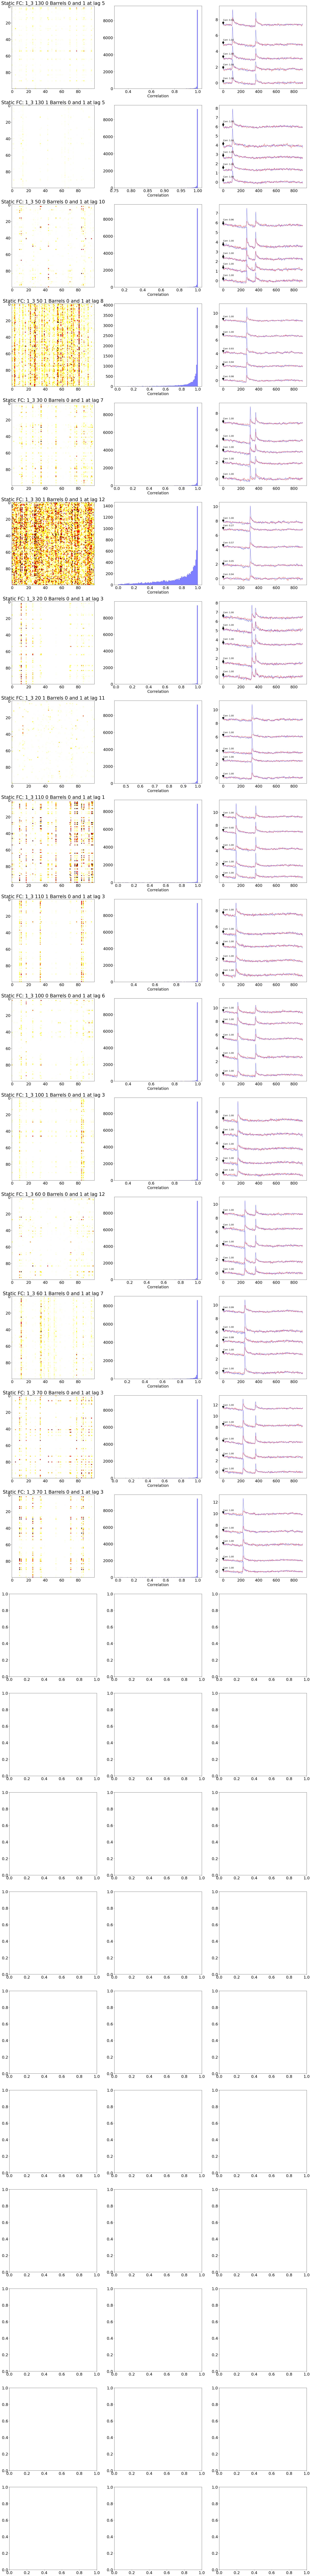

In [6]:
# now use the StaticFC class to calculate the functional connectivity matrix
# of the PPR data.
# Use the ppr_catalog_df to get the measure window(s) for each recording
# and pass that to the StaticFC class as the measure_window argument,
# per the StaticFC class docstring.
# The measure window is the time window in which to calculate the functional connectivity matrix.
# It is a tuple of the form (start_time, end_time) in ms.
missing_files = []
total_rdm_distances = []
trace_sets_dict = {}
for date in ppr_df['Date'].unique():
    date_df = ppr_df[ppr_df['Date'] == date]
    for slic in date_df['Slice'].unique():
        slic_df = date_df[date_df['Slice'] == slic]
        for loc in slic_df['Location'].unique():
            loc_df = slic_df[slic_df['Location'] == loc]
            slic_loc_id = f"{slic}_{loc}"
            
            n_ipis = len(loc_df['IPI'].unique())
            corr_matrices = {}
            fig, ax = plt.subplots(n_ipis * 2, 3, figsize=(30, 10 * n_ipis * 2))
            i_ipi = -1
            for ipi in loc_df['IPI'].unique():
                ipi_df = loc_df[loc_df['IPI'] == ipi]
                i_ipi += 1
                
                for control_or_ppr_type in ipi_df['is_single_pulse_control'].unique():
                    control_df = ipi_df[ipi_df['is_single_pulse_control'] == control_or_ppr_type]
                    i_plot = i_ipi * 2 + control_or_ppr_type
                    trace_dict = {}
                    # get the measure windows for this recording
                    measure_windows = ppr_catalog_df[(ppr_catalog_df['Slice'] == slic) & 
                                                    (ppr_catalog_df['Location'] == loc) & 
                                                    (ppr_catalog_df['Date'] == date) & 
                                                    (ppr_catalog_df['IPI'] == ipi) &
                                                    (ppr_catalog_df['is_single_pulse_control'] 
                                == control_or_ppr_type)][['pulse1_start', 
                                                            'pulse1_width', 
                                                            'pulse2_start', 
                                                            'pulse2_width']].values
                    pulse1_start = int(measure_windows[0][0])
                    pulse1_width = int(measure_windows[0][1])
                    pulse2_start = measure_windows[0][2]
                    pulse2_width = measure_windows[0][3]

                    m_windows = []
                    measure_window1 = (pulse1_start, pulse1_start + pulse1_width)
                    # if pulse2_start is nan, don't use the second measure window
                    if not np.isnan(pulse2_start):
                        measure_window2 = (int(pulse2_start), 
                                           int(pulse2_start) + int(pulse2_width))
                        m_windows.append(measure_window1)
                        m_windows.append(measure_window2)
                    else:
                        m_windows.append(measure_window1)

                    # grab the trace files from the ppr_df for this recording
                    # there should be at least 2 trace files, one for each ROI
                    trace_files = control_df['trace'].values
                    if len(trace_files) < 2:
                        print("Not enough traces for this recording")
                        continue
                    
                    # we can tell which barrel it is by the trace filename last digit before .dat 
                    for trace_file in trace_files:
                        if '_rand_' not in trace_file:
                            continue
                        i_barrel = int(trace_file.split('_rand_')[1][0])
                        

                        try:
                            traces = read_dat_trace_file(trace_file)
                        except FileNotFoundError:
                            missing_files.append(trace_file)
                            continue
                        if i_barrel not in trace_dict:
                            trace_dict[i_barrel] = []
                        # traces is a pandas dataframe, with columns ['Pt', 'ROI1', 'ROI2', ...]
                        # where each ROI is a time series for a pixel.
                        # convert this to a List of time series (e.g., pixels) from the first set.
                        trace_dict[i_barrel] += ([traces[r] 
                                                for r in traces.columns if r != 'Pt'])

                    # store the trace_dict in the trace_sets_dict
                    if date not in trace_sets_dict:
                        trace_sets_dict[date] = {}
                    if slic_loc_id not in trace_sets_dict[date]:
                        trace_sets_dict[date][slic_loc_id] = {}
                    if ipi not in trace_sets_dict[date][slic_loc_id]:
                        trace_sets_dict[date][slic_loc_id][ipi] = {}
                    if control_or_ppr_type not in trace_sets_dict[date][slic_loc_id][ipi]:
                        trace_sets_dict[date][slic_loc_id][ipi][control_or_ppr_type] = {}
                    trace_sets_dict[date][slic_loc_id][ipi][control_or_ppr_type] = trace_dict

                    barrels = list(trace_dict.keys())
                    i = 0
                    j = 1
                    if i not in barrels or j not in barrels:
                        continue
                    maxlag = 12
                    if trace_dict[barrels[i]][0].shape[0] < 3 * maxlag:
                        print("Not enough data for this recording")
                        continue
                    #for i in range(len(barrels)):
                        #for j in range(i+1, len(barrels)):
                    fc = FunctionalConnectivityMatrix(measure_windows=m_windows)
                    print("Barrels ", barrels[i], #"set:", trace_dict[barrels[i]],
                        'len:', len(trace_dict[barrels[i]]))
                    print("Barrels ", barrels[j], #"set:", trace_dict[barrels[j]],
                        'len:', len(trace_dict[barrels[j]]))
                    static_matrix, lags = fc.compute_correlation(trace_dict[barrels[i]],
                                                    trace_dict[barrels[j]],
                                                    method='granger',)

                    # store correlation matrix in the corr_matrices dict
                    if ipi not in corr_matrices:
                        corr_matrices[ipi] = {}
                    corr_matrices[ipi][control_or_ppr_type] = static_matrix

                    # visualize the static matrices at a randomly chosen lag
                    # make 3 subplots
                    random_lag = random.randint(0, len(lags) - 1)
                    ax[i_plot][0].imshow(static_matrix[:, :, random_lag], cmap='hot', interpolation='nearest',
                        vmin=0, vmax=1)

                    ax[i_plot][0].set_title(f"Static FC: {slic_loc_id} {ipi} {control_or_ppr_type} "
                                f"Barrels {barrels[i]} and {barrels[j]} at lag {lags[random_lag]}")

                    
                    # in the other subplot, show histogram of strengths of the connections
                    ax[i_plot][1].hist(static_matrix[:, :, random_lag].flatten(), bins=100, color='blue', alpha=0.5)
                    ax[i_plot][1].set_xlabel('Correlation')
                    
                                                
                    #plt.show()

                    # in the 3rd subplot, plot some example trace pairs (one from each barrel)
                    # and annotate with the correlation value
                    baseline = 0
                    for k in range(5):
                        
                        i_rand = random.randint(0, len(trace_dict[barrels[i]]) - 1)
                        j_rand = random.randint(0, len(trace_dict[barrels[j]]) - 1)
                        ax[i_plot][2].plot(trace_dict[barrels[i]][i_rand] + baseline, color='blue', alpha=0.5)
                        ax[i_plot][2].plot(trace_dict[barrels[j]][j_rand] + baseline, color='red', alpha=0.5)
                        
                        # annotate the plot with the correlation value near the baseline value
                        # get the correlation value from the static_matrix
                        # the correlation value is the value at (i_rand, j_rand) in the static_matrix
                        corr = static_matrix[i_rand, j_rand, random_lag]
                        ax[i_plot][2].annotate(f"Corr: {corr:.2f}", 
                                    xy=(0, baseline), 
                                    xytext=(0, baseline + 0.5),
                                    arrowprops=dict(facecolor='black', shrink=0.05),
                                    fontsize=12)
                        baseline += max(trace_dict[barrels[i]][i_rand].max(), 
                                        trace_dict[barrels[j]][j_rand].max()) * 1.1

            # legend shows that blue is barrel i and red is barrel j
            # if i,j == 0 label home barrel, else label barrel neighbor
            ax[0][2].legend(["Home Barrel" if k_r == 0 else "Barrel Neighbor" 
                        for k_r in [i, j]], loc='upper right')

            if not (i in barrels and j in barrels):
                plt.close(fig)
                continue

            plt.savefig(f"{output_fig_dir}/{slic_loc_id}_"
                        f"static_fc_{barrels[i]}_{barrels[j]}-xcorr.png")   

            plt.tight_layout()
            #plt.show()
            plt.close(fig)

            # Now, for each pair of (ipi1, is_single_pulse_control1) and (ipi2, is_single_pulse_control2),
            # calculate the dissimiarity of the static FC matrices.
            # Store that value in a representational dissimilarity matrix (RDM).
            # The RDM is a square matrix of size n x n, where n is the number of pairs of (ipi, is_single_pulse_control).
            # The first n/2 values are the (ipi1, is_single_pulse_control1) values for which is_single_pulse_control == 0,
            # and the second n/2 values are the (ipi2, is_single_pulse_control2) values for which is_single_pulse_control == 1.
            
            ipi_list = list(corr_matrices.keys())
            rdm = np.zeros((len(ipi_list) * 2, len(ipi_list) * 2, len(lags)))
            # sort
            ipi_list.sort()
            for i_ipi in range(len(ipi_list)):
                ipi = ipi_list[i]
                for control_or_ppr_type in corr_matrices[ipi].keys():
                    i_rdm = i_ipi + (len(ipi_list) * control_or_ppr_type)
                    fc1 = corr_matrices[ipi][control_or_ppr_type]

                    for j_ipi in range(i_ipi + 1, len(ipi_list)):
                        ipi2 = ipi_list[j_ipi]
                        for control_or_ppr_type2 in corr_matrices[ipi2].keys():
                            j_rdm = j_ipi + (len(ipi_list) * control_or_ppr_type2)
                            fc2 = corr_matrices[ipi2][control_or_ppr_type2]
                            for k_lag in range(len(lags)):
                                # calculate the dissimilarity between the two matrices (sum of squared differences)
                                rdm[i_rdm][j_rdm][k_lag] = np.sum((fc1[k_lag] - fc2[k_lag]) ** 2)
                                rdm[j_rdm][i_rdm][k_lag] = rdm[i_rdm][j_rdm][k_lag]

            # show the RDM as a heatmap
            fig, ax = plt.subplots(figsize=(10, 10))
            plt.imshow(np.mean(rdm, axis=2), cmap='hot', interpolation='nearest') #, vmin=0, vmax=7000)
            plt.colorbar()
            plt.title(f"RDM: {date} {slic_loc_id} ")
            
            # label IPIs ticks where is_single_pulse_control == 0
            plt.xticks(np.arange(len(ipi_list)), 
                        [f"{ipi} ms" for ipi in ipi_list], rotation=45)
            plt.yticks(np.arange(len(ipi_list)),
                        [f"{ipi} ms" for ipi in ipi_list])
            plt.xlabel('Recording')
            plt.ylabel('Recording')
            plt.title(f"RDM: {date} {slic_loc_id} ")
            plt.tight_layout()
            plt.savefig(f"{output_fig_dir}/{date}_{slic_loc_id}_"
                        f"rdm-xcorr.png")
            #plt.show()
            plt.close(fig)

            total_rdm_distances.append(np.sum(rdm, axis=(0, 1)))

                        

print(len(missing_files), "missing files")
for missing_file in missing_files:
    print("\t", missing_file)

one of the date/slice/locations does not have the IPI/control_or_ppr_type requested
one of the date/slice/locations does not have the IPI/control_or_ppr_type requested
one of the date/slice/locations does not have the IPI/control_or_ppr_type requested
one of the date/slice/locations does not have the IPI/control_or_ppr_type requested
one of the date/slice/locations does not have the IPI/control_or_ppr_type requested
one of the date/slice/locations does not have the IPI/control_or_ppr_type requested
one of the date/slice/locations does not have the IPI/control_or_ppr_type requested
one of the date/slice/locations does not have the IPI/control_or_ppr_type requested
one of the date/slice/locations does not have the IPI/control_or_ppr_type requested
one of the date/slice/locations does not have the IPI/control_or_ppr_type requested
one of the date/slice/locations does not have the IPI/control_or_ppr_type requested
one of the date/slice/locations does not have the IPI/control_or_ppr_type re

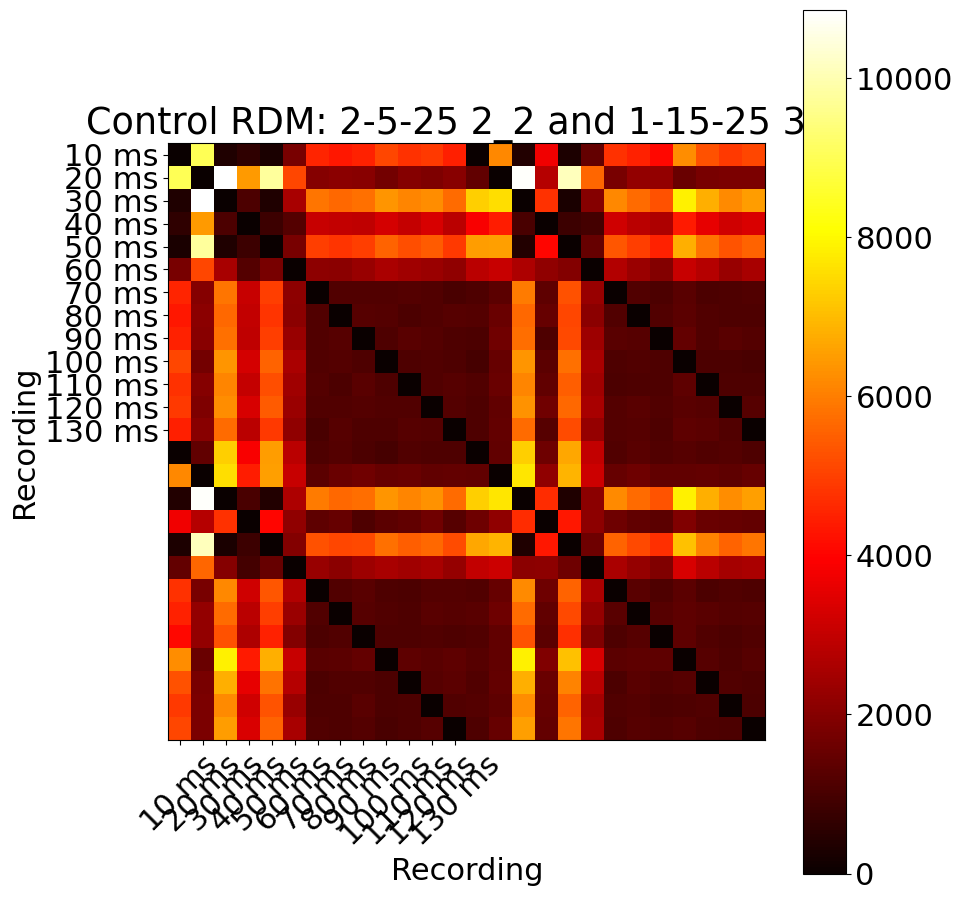

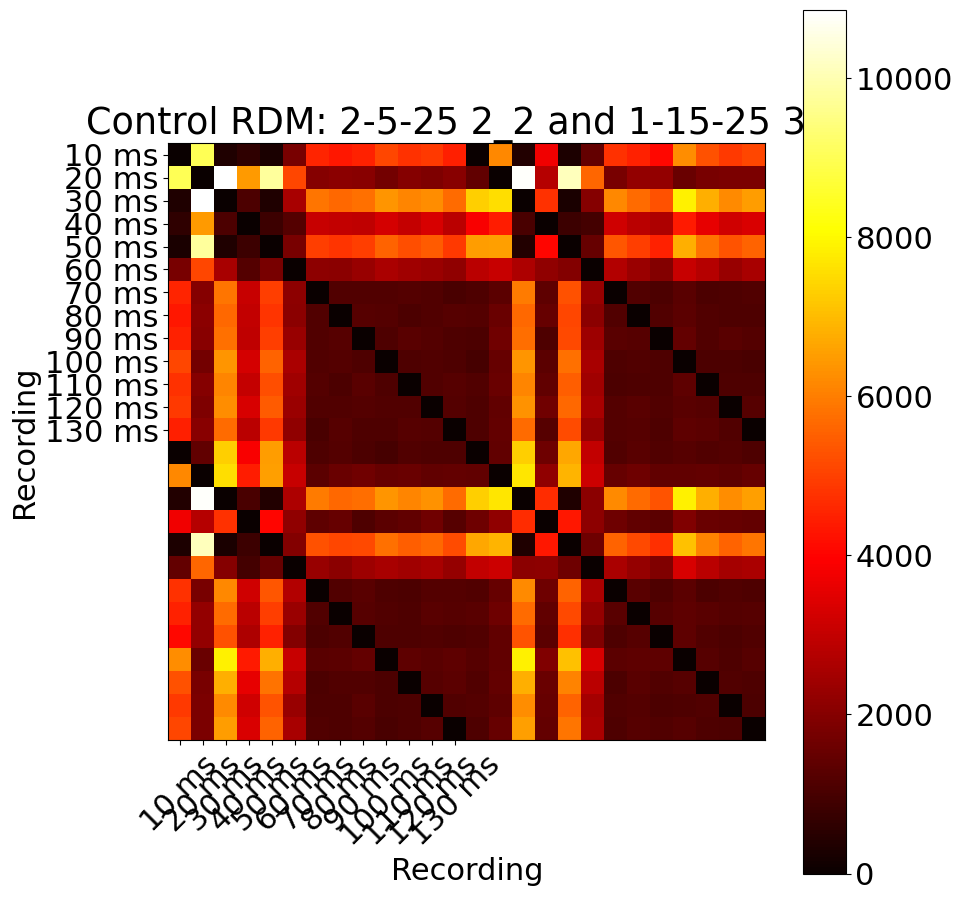

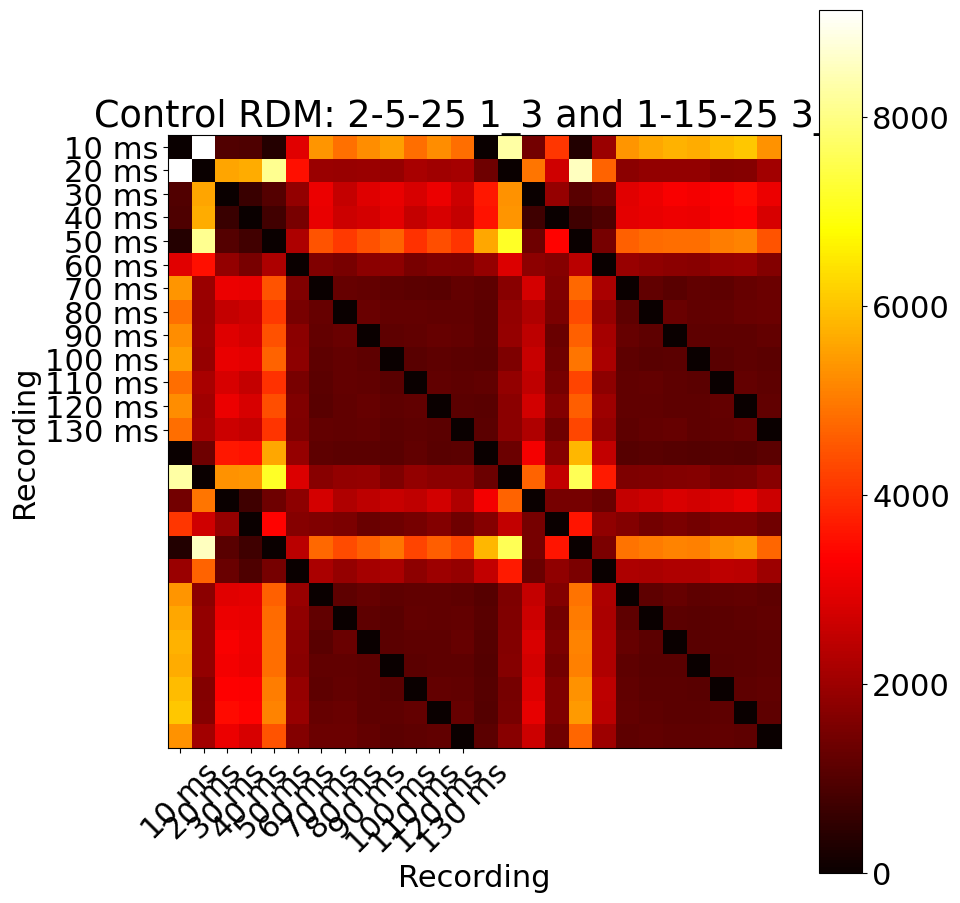

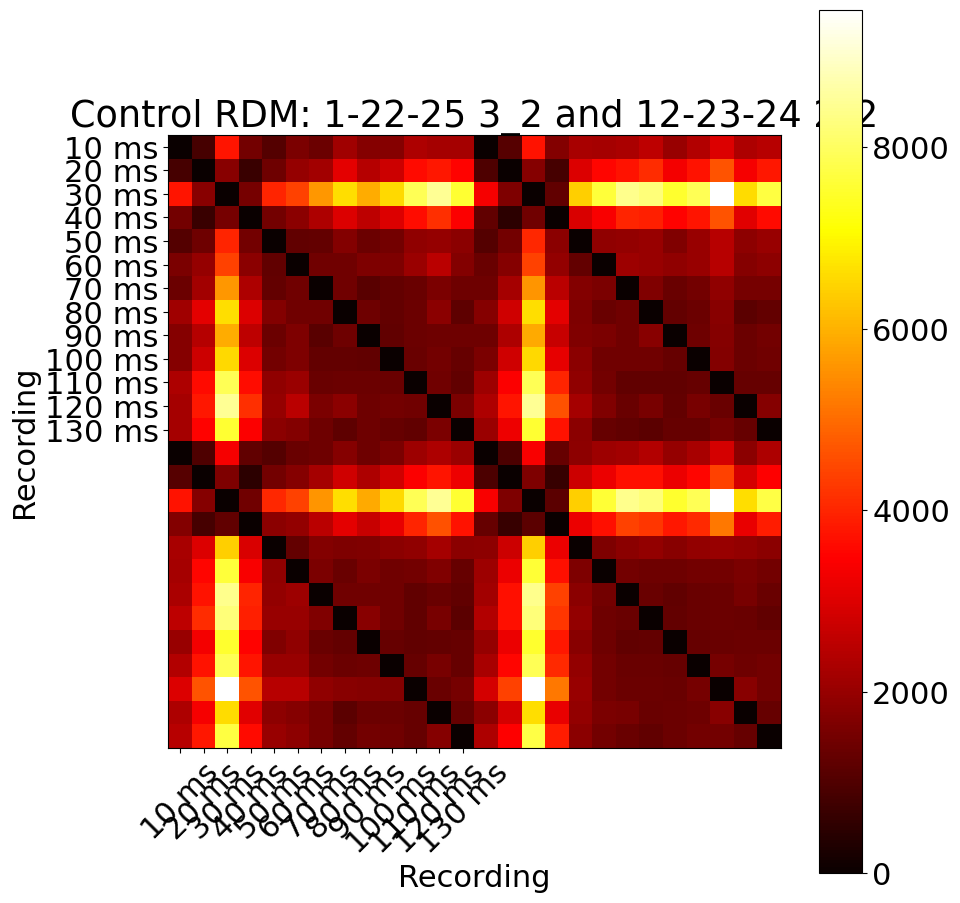

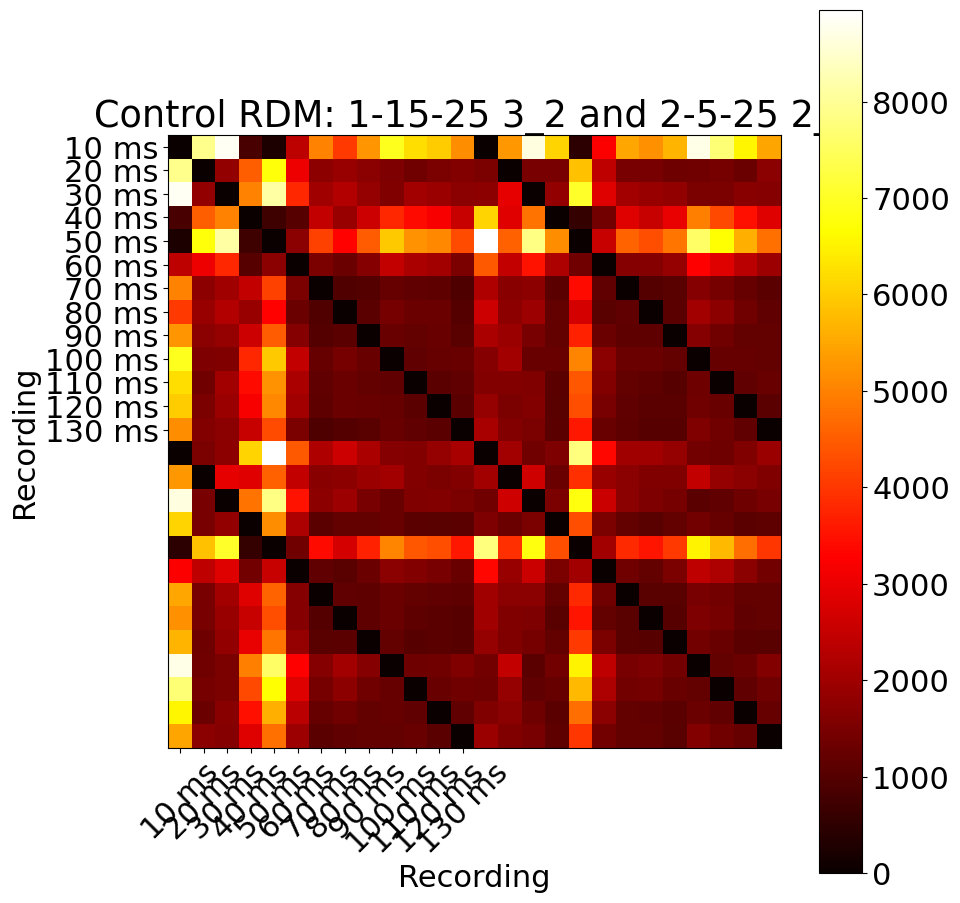

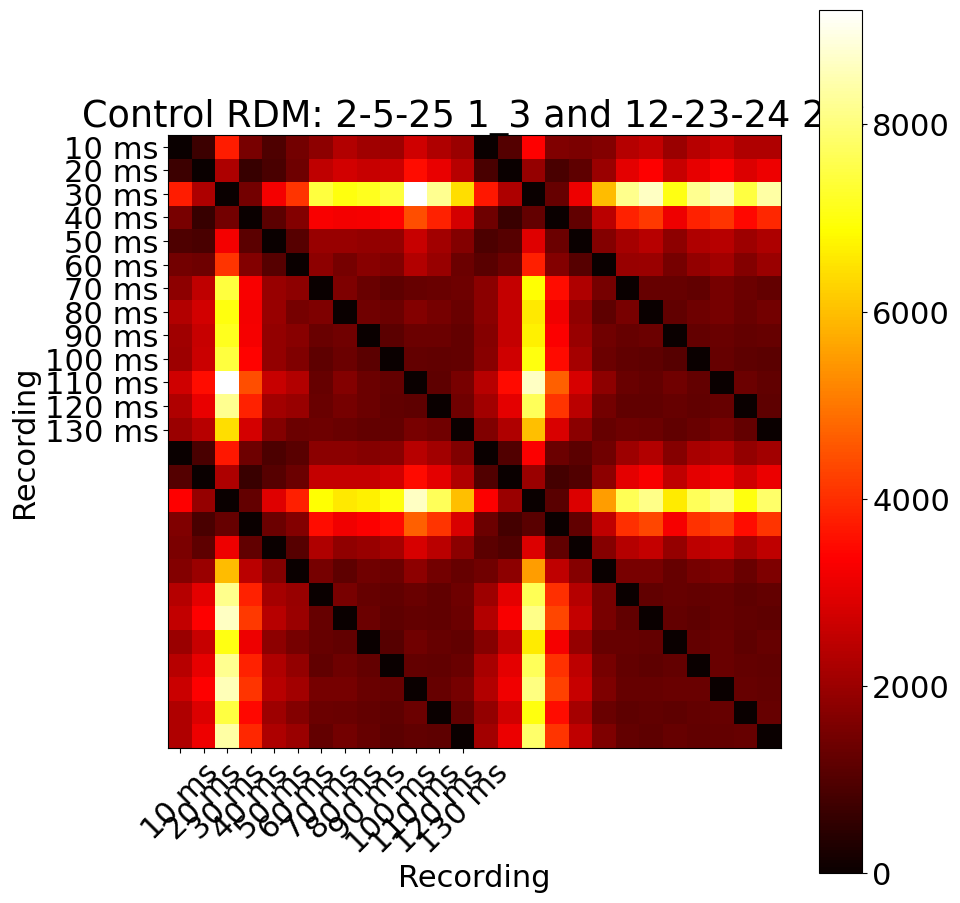

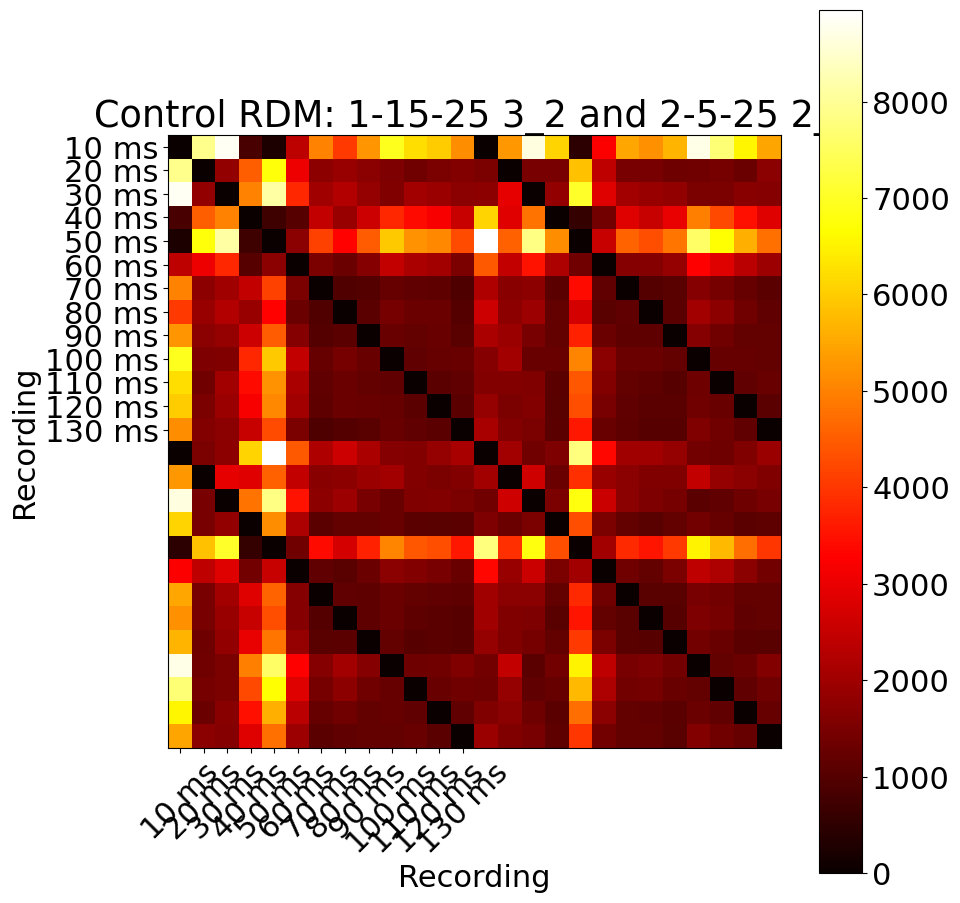

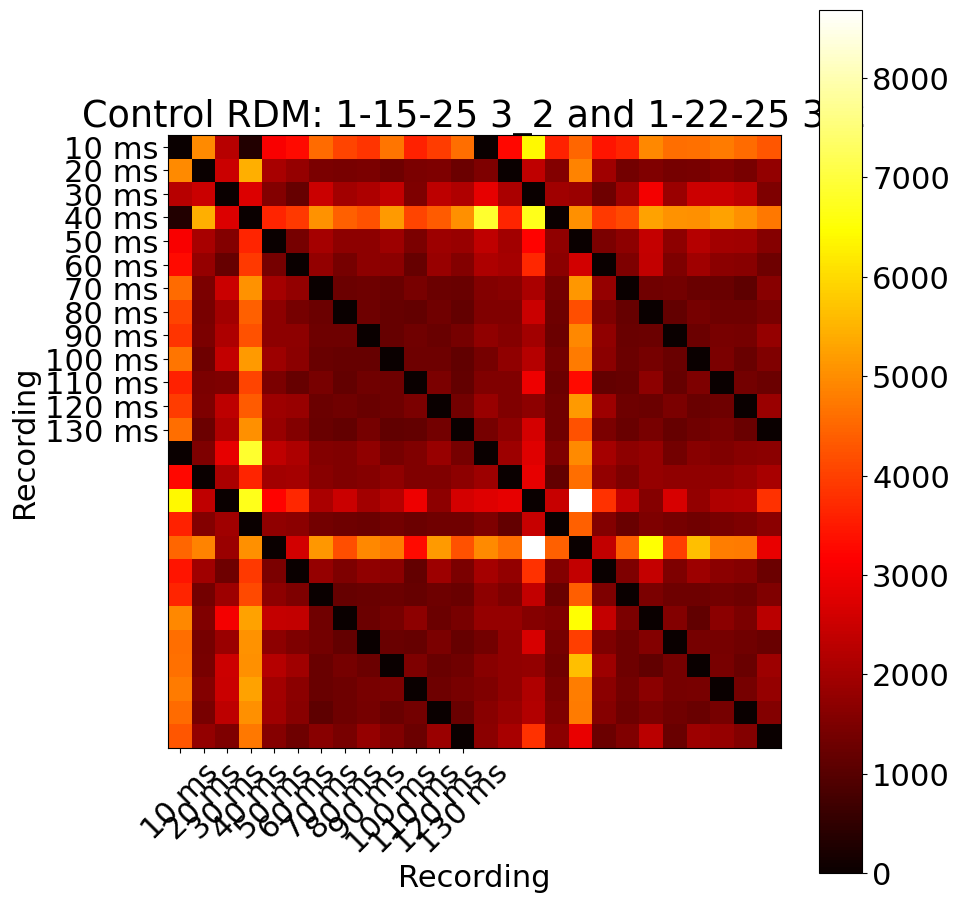

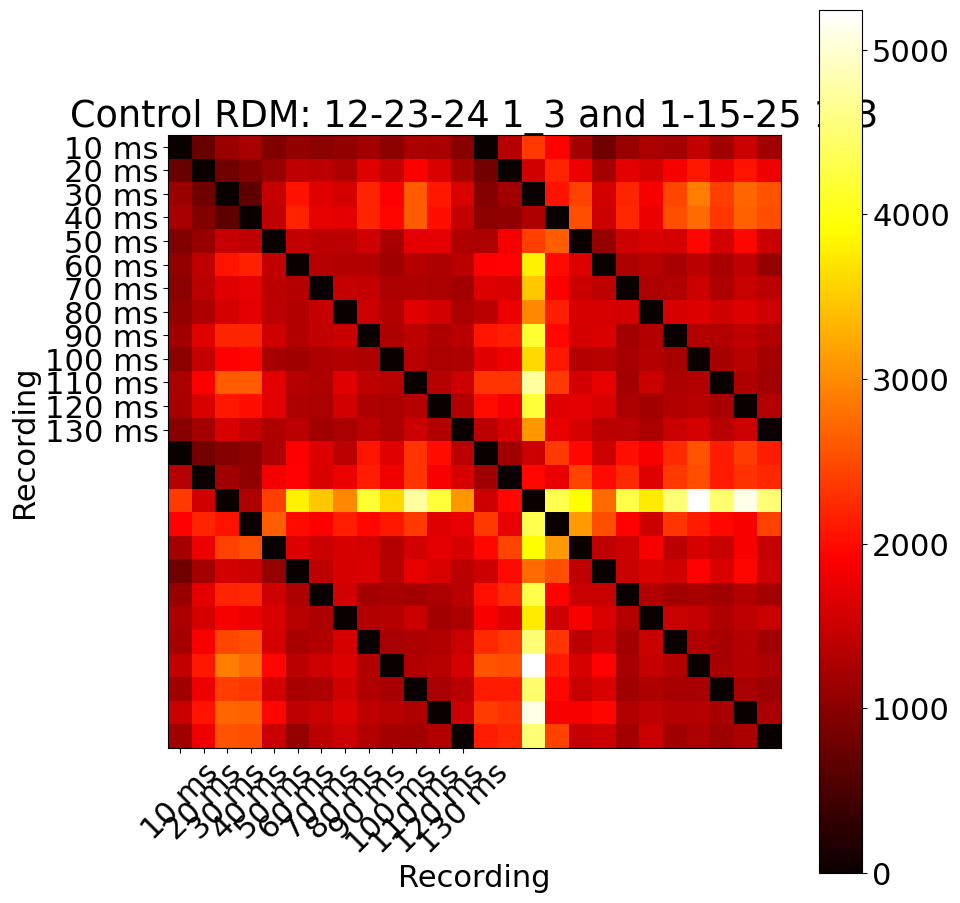

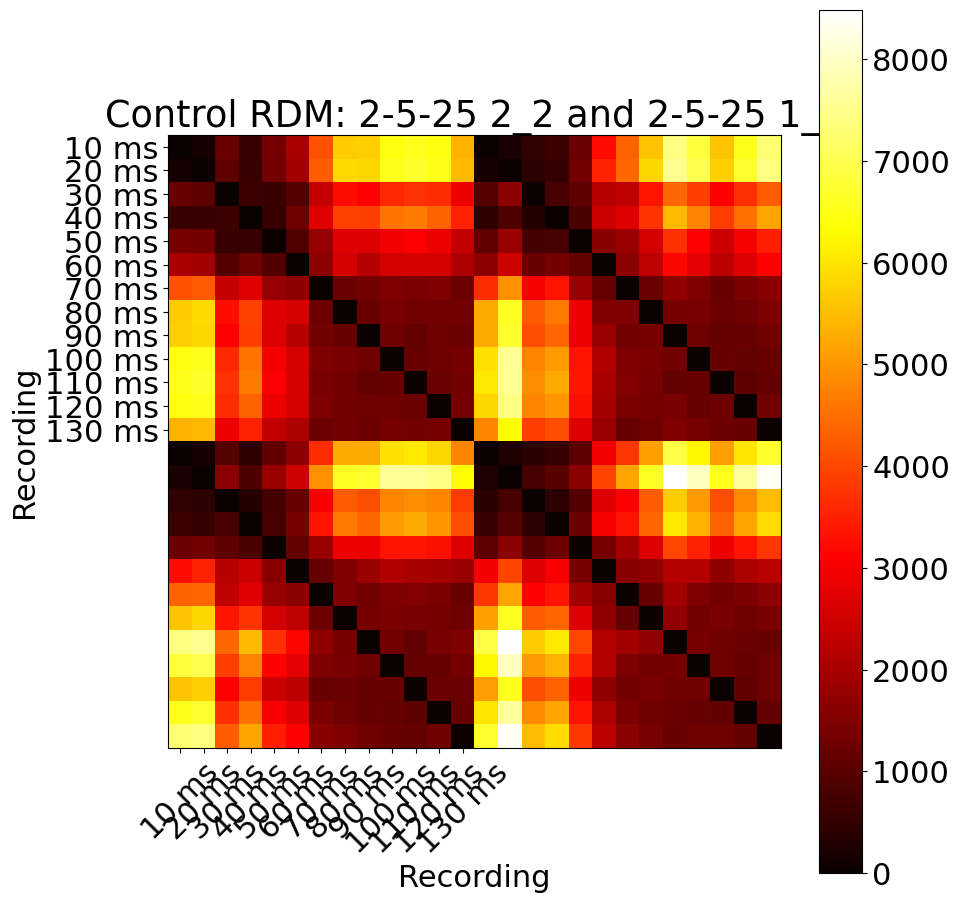

In [ ]:
# Control FCMs: use 2 barrels of same IPI and is_single_pulse_control,
# but different date, slice, and/or location.
# choose several examples and create the FCM and histogram for each.
# use the stored examples in trace_sets_dict to create the control examples.
control_rdm_distances = []
num_control_examples = 10
max_rows = 12
while num_control_examples > 0:
    # choose a random date, slice, and location from the trace_sets_dict
    date1 = random.choice(list(trace_sets_dict.keys()))
    slic_loc_id1 = random.choice(list(trace_sets_dict[date1].keys()))
    date2 = random.choice(list(trace_sets_dict.keys()))
    slic_loc_id2 = random.choice(list(trace_sets_dict[date2].keys()))

    # ensure they are not the same date, slice, and location
    while slic_loc_id1 == slic_loc_id2 and date1 == date2:
        date2 = random.choice(list(trace_sets_dict.keys()))
        slic_loc_id2 = random.choice(list(trace_sets_dict[date2].keys()))

    ipi_choices = list(trace_sets_dict[date1][slic_loc_id1].keys())
    ipi_choices = list(set(ipi_choices) & set(trace_sets_dict[date2][slic_loc_id2].keys()))
    if len(ipi_choices) == 0:
        print("No IPI choices for this date/slice/location pair")
        continue
    n_ipis = len(ipi_choices)
    fig, ax = plt.subplots(min(max_rows, n_ipis * 2), 3, figsize=(30, 10 * min(max_rows, n_ipis * 2)))
    i_ipi = -1
    corr_matrices = {}
    for ipi in ipi_choices:
        i_ipi += 1

        control_ppr_choices = list(trace_sets_dict[date1][slic_loc_id1][ipi].keys())
        control_ppr_choices = list(set(control_ppr_choices) &
            set(trace_sets_dict[date2][slic_loc_id2][ipi].keys()))

        for control_or_ppr_type in control_ppr_choices:

            i_plot = 2 * i_ipi + control_or_ppr_type
                

            try:
                barrels1 = trace_sets_dict[date1][slic_loc_id1][ipi][control_or_ppr_type]
                barrels2 = trace_sets_dict[date2][slic_loc_id2][ipi][control_or_ppr_type]
                traces1 = barrels1[0]
                traces2 = barrels2[1]
            except KeyError:
                print("one of the date/slice/locations does not have the IPI/control_or_ppr_type requested")
                continue
            

            # create the functional connectivity matrix
            fc = FunctionalConnectivityMatrix(measure_windows=m_windows)
            static_matrix, lags = fc.compute_correlation(traces1, traces2,
                                        method='granger',)

            # store correlation matrix in the corr_matrices dict
            if ipi not in corr_matrices:
                corr_matrices[ipi] = {}
            corr_matrices[ipi][control_or_ppr_type] = static_matrix

            print("Static matrix shape: ", static_matrix.shape)

            # visualize the static matrix
            # make 2 subplots
            
            random_lag = random.randint(0, len(lags) - 1)
            if i_plot < max_rows:
                ax[i_plot][0].imshow(static_matrix[:, :, random_lag], cmap='hot', interpolation='nearest',
                    vmin=0, vmax=1)

                ax[i_plot][1].set_title(f"Control FC: {date1} {slic_loc_id1} Home Barrel and "
                            f"{date2} {slic_loc_id2} Neighbor Barrel " + (f" for IPI {ipi} ms " if control_or_ppr_type == 0 else "")
                            f"at lag {lags[random_lag]}")

                
                # in the other subplot, show histogram of strengths of the connections
                ax[i_plot][1].hist(static_matrix[:, :, random_lag].flatten(), bins=100, color='blue', alpha=0.5)
                ax[i_plot][1].set_xlabel('Correlation')
            
                # show random trace pairs (one from each barrel)
                baseline = 0
                for k in range(5):
                    i_rand = random.randint(0, len(traces1) - 1)
                    j_rand = random.randint(0, len(traces2) - 1)
                    ax[i_plot][2].plot(traces1[i_rand] + baseline, color='blue', alpha=0.5)
                    ax[i_plot][2].plot(traces2[j_rand] + baseline, color='red', alpha=0.5)
                    
                    # annotate the plot with the correlation value near the baseline value
                    # get the correlation value from the static_matrix
                    # the correlation value is the value at (i_rand, j_rand) in the static_matrix
                    corr = static_matrix[i_rand, j_rand, random_lag]
                    ax[i_plot][2].annotate(f"Corr: {corr:.2f}", 
                                xy=(0, baseline), 
                                xytext=(0, baseline + 0.5),
                                arrowprops=dict(facecolor='black', shrink=0.05),
                                fontsize=12)
                    baseline += max(traces1[i_rand].max(), traces2[j_rand].max()) * 1.1
            
    if len(corr_matrices.keys()) == 0:
        print("No correlation matrices found")
        plt.close(fig)
        continue
    plt.savefig(f"{output_fig_dir}/{slic_loc_id}_"
                f"static_fc_control-xcorr.png")
    #plt.show()
    plt.close(fig)

    # compute RDM for the control examples
    # The RDM is a square matrix of size n x n, where n is the number of pairs of (ipi, is_single_pulse_control).
    # The first n/2 values are the (ipi1, is_single_pulse_control1) values for which is_single_pulse_control == 0,
    # and the second n/2 values are the (ipi2, is_single_pulse_control2) values for which is_single_pulse_control == 1.
    # The RDM is a square matrix of size n x n, where n is the number of pairs of (ipi, is_single_pulse_control).
    # The first n/2 values are the (ipi1, is_single_pulse_control1) values for which is_single_pulse_control == 0,
    # and the second n/2 values are the (ipi2, is_single_pulse_control2) values for which is_single_pulse_control == 1.
    ipi_list = list(corr_matrices.keys())
    ipi_list.sort()
    rdm = np.zeros((len(ipi_list) * 2, len(ipi_list) * 2, len(lags)))

    for i_ipi in range(len(ipi_list)):
        ipi = ipi_list[i_ipi]
        for control_or_ppr_type in corr_matrices[ipi].keys():
            i_rdm = i_ipi + (len(ipi_list) * control_or_ppr_type)
            fc1 = corr_matrices[ipi][control_or_ppr_type]

            for j_ipi in range(i_ipi + 1, len(ipi_list)):
                ipi2 = ipi_list[j_ipi]
                for control_or_ppr_type2 in corr_matrices[ipi2].keys():
                    j_rdm = j_ipi + (len(ipi_list) * control_or_ppr_type2)
                    fc2 = corr_matrices[ipi2][control_or_ppr_type2]

                    for k_lag in range(len(lags)):
                        # calculate the dissimilarity between the two matrices (sum of squared differences)
                        rdm[i_rdm][j_rdm][k_lag] = np.sum((fc1[k_lag] - fc2[k_lag]) ** 2)
                        rdm[j_rdm][i_rdm][k_lag] = rdm[i_rdm][j_rdm][k_lag]

    # show the RDM as a heatmap
    fig, ax = plt.subplots(figsize=(10, 10))
    plt.imshow(rdm, cmap='hot', interpolation='nearest') #, vmin=0, vmax=7000)
    plt.colorbar()
    plt.title(f"Control RDM: {date1} {slic_loc_id1} and {date2} {slic_loc_id2}")

    # label IPIs ticks where is_single_pulse_control == 0
    plt.xticks(np.arange(len(ipi_list)), 
                [f"{ipi} ms" for ipi in ipi_list], rotation=45)
    plt.yticks(np.arange(len(ipi_list)),
                [f"{ipi} ms" for ipi in ipi_list])
    plt.xlabel('Recording')
    plt.ylabel('Recording')
    plt.title(f"Control RDM: {date1} {slic_loc_id1} and {date2} {slic_loc_id2}")
    plt.tight_layout()
    plt.savefig(f"{output_fig_dir}/{date1}_{slic_loc_id1}_{date2}_{slic_loc_id2}_"
                f"rdm_control-xcorr.png")
    #plt.show()
    control_rdm_distances.append(np.sum(rdm, axis=(0, 1)))
    num_control_examples -= 1

In [ ]:
total_rdm_distances

[62198.24081585765,
 1256717.170145797,
 1012962.3547100826,
 1256143.8677920832,
 569032.2070890425,
 1556258.2604821979,
 562065.0801856569,
 299794.7093178493]

t-statistic: -4.105034497081499, p-value: 0.0008277699993260981
The two groups are significantly different


C:\Users\jjudge3\AppData\Local\Temp\ipykernel_276\3777423013.py:30: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax.set_xticks([0, 1], ['Data', 'Control'])


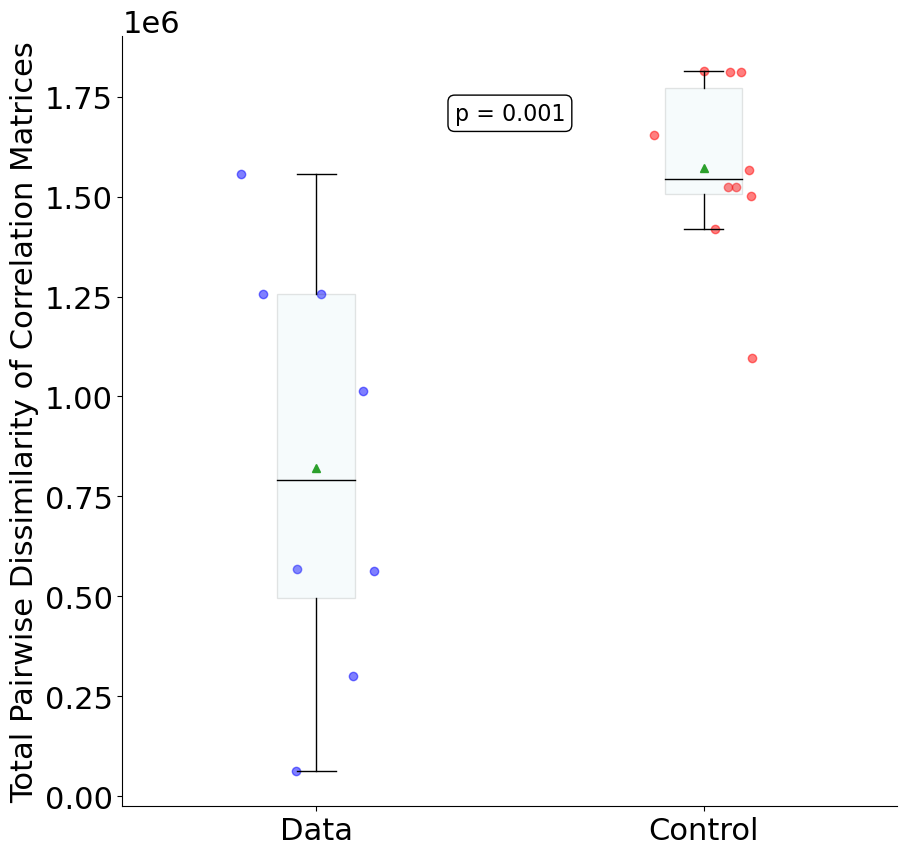

In [ ]:
# scatter plot of the total_rdm_distances and control_rdm_distances
fig, ax = plt.subplots(figsize=(10, 10))


for k_lag in range(len(lags)):
    # plot the total_rdm_distances and control_rdm_distances for each lag
    
    # add box and whisker plot for each group
    # make boxplot transparent
    lag = lags[k_lag]
    rdm_lagged = [r[k_lag] for r in total_rdm_distances]
    control_rdm_lagged = [r[k_lag] for r in control_rdm_distances]
    ax.boxplot([rdm_lagged, control_rdm_lagged], 
                positions=[lag-0.25, lag+0.25], widths=0.2, patch_artist=True,
                boxprops=dict(facecolor='lightblue', alpha=0.1),
                showfliers=False,
                medianprops=dict(color='black'), showmeans=True)
                
    x_jitter = np.random.normal(0, 0.1, len(total_rdm_distances)) + lag - 0.25
    x_jitter2 = np.random.normal(0, 0.1, len(control_rdm_distances)) + lag + 0.25
    ax.scatter(x_jitter, rdm_lagged, color='blue', alpha=0.5, label='Data')
    ax.scatter(x_jitter2, control_rdm_lagged, color='red', alpha=0.5, label='Control (scrambled)')
'''
# use ttest_ind to compare the two groups
t_stat, p_val = ttest_ind(total_rdm_distances, control_rdm_distances)
print(f"t-statistic: {t_stat}, p-value: {p_val}")
if p_val < 0.05:
    print("The two groups are significantly different")
    # mark the p-value on the plot
    ax.annotate(f"p = {p_val:.3f}", xy=(0.5, 0.9), xycoords='axes fraction',
                fontsize=16, ha='center', va='center', color='black',
                bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='white'))
'''
#ax.set_xlim(-0.5, 1.5)
ax.set_xticks([0, 1], ['Data', 'Control'])
ax.set_xticklabels(['Data', 'Control'])

# turn of spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_ylabel('Total Pairwise Dissimilarity of Correlation Matrices')
plt.savefig(f"{output_fig_dir}/total_rdm_distances.png")
plt.show()
plt.close(fig)

## 